In [3]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 + 5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid' ,'tf_is','tf_fid']
if not os.path.isdir('saved_models_{}'.format('infogan')):
    os.mkdir('saved_models_{}'.format('infogan'))
f = open('saved_models_{}/log_collapse1.txt'.format('infogan'), mode='w')
import torch.utils.data as Data


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 6272)              457856    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 14, 14, 128)       512       
__________

0 [D loss: 0.31, acc.: 80.47%] [Q loss: 2.25] [G loss: 0.63]
0 [D loss: 0.30, acc.: 87.50%] [Q loss: 2.23] [G loss: 0.66]
0 [D loss: 0.32, acc.: 82.81%] [Q loss: 2.47] [G loss: 0.95]
0 [D loss: 0.48, acc.: 72.66%] [Q loss: 2.62] [G loss: 1.01]
0 [D loss: 0.27, acc.: 87.50%] [Q loss: 2.19] [G loss: 0.87]
0 [D loss: 0.37, acc.: 79.69%] [Q loss: 2.32] [G loss: 0.62]
0 [D loss: 0.40, acc.: 78.91%] [Q loss: 2.52] [G loss: 0.99]
0 [D loss: 0.36, acc.: 78.91%] [Q loss: 2.78] [G loss: 0.63]
0 [D loss: 0.28, acc.: 89.06%] [Q loss: 2.50] [G loss: 0.64]
0 [D loss: 0.40, acc.: 73.44%] [Q loss: 2.55] [G loss: 0.60]
0 [D loss: 0.26, acc.: 89.84%] [Q loss: 2.41] [G loss: 0.69]
0 [D loss: 0.33, acc.: 82.81%] [Q loss: 2.16] [G loss: 0.60]
0 [D loss: 0.31, acc.: 85.94%] [Q loss: 2.13] [G loss: 0.75]
0 [D loss: 0.45, acc.: 73.44%] [Q loss: 2.56] [G loss: 0.81]
0 [D loss: 0.35, acc.: 81.25%] [Q loss: 2.48] [G loss: 0.59]
0 [D loss: 0.40, acc.: 79.69%] [Q loss: 2.17] [G loss: 0.64]
0 [D loss: 0.39, acc.: 7

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0


/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ot/lp/__init__.py:211: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


compute score in space: 1
IS socre: 3.467217
FID: 124.604347
0 = 21.349380230712796
1 = 0.33848994911519614
2 = 0.996399998664856
3 = 0.9998000264167786
4 = 0.9929999709129333
5 = 0.993047297000885
6 = 0.9998000264167786
7 = 13.382367876684711
8 = 0.22336265537538993
9 = 0.9756500124931335
10 = 0.9692000150680542
11 = 0.9821000099182129
12 = 0.9818660616874695
13 = 0.9692000150680542
14 = 3.4672253131866455
15 = 8.020262718200684
16 = 0.44052785634994507
17 = 3.467216730117798
18 = 124.6043472290039
0 [D loss: 0.58, acc.: 71.09%] [Q loss: 1.78] [G loss: 0.16]
0 [D loss: 0.64, acc.: 63.28%] [Q loss: 1.61] [G loss: 0.18]
0 [D loss: 0.78, acc.: 54.69%] [Q loss: 1.50] [G loss: 0.17]
0 [D loss: 0.64, acc.: 68.75%] [Q loss: 1.69] [G loss: 0.23]
0 [D loss: 0.72, acc.: 56.25%] [Q loss: 1.47] [G loss: 0.19]
0 [D loss: 0.55, acc.: 74.22%] [Q loss: 1.54] [G loss: 0.21]
0 [D loss: 0.72, acc.: 56.25%] [Q loss: 1.56] [G loss: 0.25]
0 [D loss: 0.62, acc.: 62.50%] [Q loss: 1.64] [G loss: 0.17]
0 [D lo

0 [D loss: 0.69, acc.: 62.50%] [Q loss: 1.27] [G loss: 0.14]
0 [D loss: 0.76, acc.: 56.25%] [Q loss: 1.18] [G loss: 0.04]
0 [D loss: 0.63, acc.: 60.94%] [Q loss: 1.46] [G loss: 0.08]
0 [D loss: 0.62, acc.: 62.50%] [Q loss: 1.21] [G loss: 0.13]
0 [D loss: 0.71, acc.: 64.06%] [Q loss: 1.19] [G loss: 0.15]
0 [D loss: 0.70, acc.: 58.59%] [Q loss: 1.28] [G loss: 0.14]
0 [D loss: 0.64, acc.: 64.06%] [Q loss: 1.27] [G loss: 0.09]
0 [D loss: 0.72, acc.: 60.16%] [Q loss: 1.21] [G loss: 0.06]
0 [D loss: 0.68, acc.: 60.94%] [Q loss: 1.19] [G loss: 0.04]
0 [D loss: 0.74, acc.: 65.62%] [Q loss: 1.25] [G loss: 0.07]
0 [D loss: 0.62, acc.: 63.28%] [Q loss: 1.32] [G loss: 0.05]
0 [D loss: 0.69, acc.: 59.38%] [Q loss: 1.20] [G loss: 0.06]
0 [D loss: 0.62, acc.: 61.72%] [Q loss: 1.24] [G loss: 0.07]
0 [D loss: 0.72, acc.: 56.25%] [Q loss: 1.11] [G loss: 0.07]
0 [D loss: 0.67, acc.: 62.50%] [Q loss: 1.23] [G loss: 0.14]
0 [D loss: 0.62, acc.: 64.06%] [Q loss: 1.24] [G loss: 0.15]
0 [D loss: 0.62, acc.: 6

0 [D loss: 0.68, acc.: 62.50%] [Q loss: 1.04] [G loss: 0.04]
0 [D loss: 0.66, acc.: 64.06%] [Q loss: 1.25] [G loss: 0.06]
0 [D loss: 0.78, acc.: 54.69%] [Q loss: 1.03] [G loss: 0.07]
0 [D loss: 0.76, acc.: 60.16%] [Q loss: 1.05] [G loss: 0.02]
0 [D loss: 0.67, acc.: 55.47%] [Q loss: 1.07] [G loss: 0.08]
0 [D loss: 0.76, acc.: 55.47%] [Q loss: 1.14] [G loss: 0.09]
0 [D loss: 0.73, acc.: 58.59%] [Q loss: 1.12] [G loss: 0.12]
0 [D loss: 0.70, acc.: 60.94%] [Q loss: 1.07] [G loss: 0.09]
0 [D loss: 0.67, acc.: 59.38%] [Q loss: 1.15] [G loss: 0.07]
0 [D loss: 0.66, acc.: 59.38%] [Q loss: 1.15] [G loss: 0.09]
0 [D loss: 0.67, acc.: 59.38%] [Q loss: 1.21] [G loss: 0.05]
0 [D loss: 0.69, acc.: 52.34%] [Q loss: 1.18] [G loss: 0.05]
0 [D loss: 0.62, acc.: 63.28%] [Q loss: 1.16] [G loss: 0.08]
0 [D loss: 0.61, acc.: 63.28%] [Q loss: 1.05] [G loss: 0.06]
0 [D loss: 0.76, acc.: 58.59%] [Q loss: 1.04] [G loss: 0.06]
0 [D loss: 0.74, acc.: 63.28%] [Q loss: 1.13] [G loss: 0.03]
0 [D loss: 0.75, acc.: 5

0 [D loss: 0.74, acc.: 50.00%] [Q loss: 0.99] [G loss: 0.06]
0 [D loss: 0.75, acc.: 58.59%] [Q loss: 0.99] [G loss: 0.04]
0 [D loss: 0.67, acc.: 60.16%] [Q loss: 1.04] [G loss: 0.08]
0 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.95] [G loss: 0.07]
0 [D loss: 0.81, acc.: 53.91%] [Q loss: 0.91] [G loss: 0.05]
0 [D loss: 0.72, acc.: 60.16%] [Q loss: 0.99] [G loss: 0.03]
0 [D loss: 0.70, acc.: 60.94%] [Q loss: 1.03] [G loss: 0.07]
0 [D loss: 0.72, acc.: 55.47%] [Q loss: 1.08] [G loss: 0.08]
0 [D loss: 0.67, acc.: 65.62%] [Q loss: 0.99] [G loss: 0.03]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 4.438132
FID: 80.038689
0 = 19.604874035167665
1 = 0.2735196671327505
2 = 0.9822499752044678
3 = 0.9984999895095825
4 = 0.9660000205039978
5 = 0.9670702219009399
6 = 0.9984999895095825
7 = 12.02040144187213
8 = 0.188987868530229
9 = 0.9429500102996826
10 = 0.9492999911308289
11 = 0.9366000294685364
12 = 0.9373950958251953
13 = 0.9492999911308289
14 = 4.43815326690673

0 [D loss: 0.73, acc.: 54.69%] [Q loss: 0.92] [G loss: 0.04]
0 [D loss: 0.79, acc.: 56.25%] [Q loss: 0.94] [G loss: 0.06]
0 [D loss: 0.73, acc.: 59.38%] [Q loss: 0.97] [G loss: 0.04]
0 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.99] [G loss: 0.03]
0 [D loss: 0.77, acc.: 53.12%] [Q loss: 0.80] [G loss: 0.06]
0 [D loss: 0.78, acc.: 50.78%] [Q loss: 0.85] [G loss: 0.08]
0 [D loss: 0.71, acc.: 64.06%] [Q loss: 0.91] [G loss: 0.06]
0 [D loss: 0.72, acc.: 60.94%] [Q loss: 0.98] [G loss: 0.03]
0 [D loss: 0.72, acc.: 57.81%] [Q loss: 0.92] [G loss: 0.03]
0 [D loss: 0.78, acc.: 56.25%] [Q loss: 0.97] [G loss: 0.03]
0 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.96] [G loss: 0.02]
0 [D loss: 0.73, acc.: 53.91%] [Q loss: 1.04] [G loss: 0.05]
0 [D loss: 0.55, acc.: 71.09%] [Q loss: 0.94] [G loss: 0.01]
0 [D loss: 0.66, acc.: 62.50%] [Q loss: 0.92] [G loss: 0.05]
0 [D loss: 0.65, acc.: 62.50%] [Q loss: 1.03] [G loss: 0.08]
0 [D loss: 0.73, acc.: 60.94%] [Q loss: 0.95] [G loss: 0.03]
0 [D loss: 0.69, acc.: 6

0 [D loss: 0.74, acc.: 58.59%] [Q loss: 0.86] [G loss: 0.05]
0 [D loss: 0.70, acc.: 64.06%] [Q loss: 0.96] [G loss: 0.10]
0 [D loss: 0.73, acc.: 57.81%] [Q loss: 0.86] [G loss: 0.06]
0 [D loss: 0.72, acc.: 61.72%] [Q loss: 1.02] [G loss: 0.03]
0 [D loss: 0.70, acc.: 57.81%] [Q loss: 1.01] [G loss: 0.07]
0 [D loss: 0.70, acc.: 63.28%] [Q loss: 0.88] [G loss: 0.09]
0 [D loss: 0.66, acc.: 61.72%] [Q loss: 1.05] [G loss: 0.05]
0 [D loss: 0.64, acc.: 62.50%] [Q loss: 0.98] [G loss: 0.03]
0 [D loss: 0.70, acc.: 58.59%] [Q loss: 0.85] [G loss: 0.11]
0 [D loss: 0.75, acc.: 59.38%] [Q loss: 0.90] [G loss: 0.05]
0 [D loss: 0.71, acc.: 63.28%] [Q loss: 0.96] [G loss: 0.04]
0 [D loss: 0.67, acc.: 65.62%] [Q loss: 0.89] [G loss: 0.03]
0 [D loss: 0.70, acc.: 64.06%] [Q loss: 1.01] [G loss: 0.01]
0 [D loss: 0.67, acc.: 64.84%] [Q loss: 0.87] [G loss: 0.03]
0 [D loss: 0.68, acc.: 65.62%] [Q loss: 0.91] [G loss: 0.06]
0 [D loss: 0.71, acc.: 57.81%] [Q loss: 0.91] [G loss: 0.04]
0 [D loss: 0.72, acc.: 5

1 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.90] [G loss: 0.02]
1 [D loss: 0.64, acc.: 61.72%] [Q loss: 1.01] [G loss: 0.04]
1 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.92] [G loss: 0.02]
1 [D loss: 0.74, acc.: 60.94%] [Q loss: 0.89] [G loss: 0.05]
1 [D loss: 0.69, acc.: 57.81%] [Q loss: 1.02] [G loss: 0.03]
1 [D loss: 0.70, acc.: 60.16%] [Q loss: 0.90] [G loss: 0.02]
1 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.92] [G loss: 0.01]
1 [D loss: 0.72, acc.: 61.72%] [Q loss: 0.94] [G loss: 0.06]
1 [D loss: 0.65, acc.: 66.41%] [Q loss: 0.94] [G loss: 0.02]
1 [D loss: 0.72, acc.: 57.81%] [Q loss: 0.98] [G loss: 0.09]
1 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.86] [G loss: 0.01]
1 [D loss: 0.74, acc.: 60.16%] [Q loss: 0.86] [G loss: 0.14]
1 [D loss: 0.71, acc.: 59.38%] [Q loss: 0.88] [G loss: 0.03]
1 [D loss: 0.70, acc.: 59.38%] [Q loss: 0.91] [G loss: 0.01]
1 [D loss: 0.65, acc.: 62.50%] [Q loss: 0.99] [G loss: 0.01]
1 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.90] [G loss: 0.04]
1 [D loss: 0.71, acc.: 5

1 [D loss: 0.71, acc.: 60.94%] [Q loss: 0.93] [G loss: 0.03]
1 [D loss: 0.70, acc.: 60.16%] [Q loss: 1.02] [G loss: 0.02]
1 [D loss: 0.65, acc.: 64.06%] [Q loss: 0.98] [G loss: 0.03]
1 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.89] [G loss: 0.04]
1 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.97] [G loss: 0.02]
1 [D loss: 0.73, acc.: 59.38%] [Q loss: 0.96] [G loss: 0.16]
1 [D loss: 0.65, acc.: 63.28%] [Q loss: 0.85] [G loss: 0.01]
1 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.90] [G loss: 0.04]
1 [D loss: 0.78, acc.: 51.56%] [Q loss: 0.93] [G loss: 0.02]
1 [D loss: 0.72, acc.: 58.59%] [Q loss: 0.94] [G loss: 0.05]
1 [D loss: 0.70, acc.: 55.47%] [Q loss: 1.03] [G loss: 0.04]
1 [D loss: 0.72, acc.: 62.50%] [Q loss: 0.86] [G loss: 0.04]
1 [D loss: 0.70, acc.: 57.81%] [Q loss: 0.92] [G loss: 0.02]
1 [D loss: 0.62, acc.: 64.84%] [Q loss: 0.92] [G loss: 0.03]
1 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.90] [G loss: 0.01]
1 [D loss: 0.78, acc.: 55.47%] [Q loss: 0.86] [G loss: 0.04]
1 [D loss: 0.64, acc.: 6

1 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.87] [G loss: 0.07]
1 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.92] [G loss: 0.03]
1 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.85] [G loss: 0.02]
1 [D loss: 0.81, acc.: 50.78%] [Q loss: 0.84] [G loss: 0.06]
1 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.97] [G loss: 0.03]
1 [D loss: 0.72, acc.: 54.69%] [Q loss: 0.98] [G loss: 0.01]
1 [D loss: 0.75, acc.: 58.59%] [Q loss: 0.95] [G loss: 0.02]
1 [D loss: 0.74, acc.: 60.16%] [Q loss: 0.91] [G loss: 0.01]
1 [D loss: 0.74, acc.: 57.81%] [Q loss: 0.90] [G loss: 0.05]
1 [D loss: 0.62, acc.: 64.06%] [Q loss: 1.00] [G loss: 0.01]
1 [D loss: 0.64, acc.: 63.28%] [Q loss: 0.98] [G loss: 0.11]
1 [D loss: 0.64, acc.: 64.06%] [Q loss: 1.00] [G loss: 0.01]
1 [D loss: 0.70, acc.: 55.47%] [Q loss: 1.00] [G loss: 0.03]
1 [D loss: 0.72, acc.: 55.47%] [Q loss: 0.91] [G loss: 0.01]
1 [D loss: 0.77, acc.: 55.47%] [Q loss: 0.87] [G loss: 0.07]
1 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.85] [G loss: 0.02]
1 [D loss: 0.71, acc.: 5

1 [D loss: 0.68, acc.: 63.28%] [Q loss: 0.87] [G loss: 0.02]
1 [D loss: 0.72, acc.: 57.81%] [Q loss: 0.92] [G loss: 0.05]
1 [D loss: 0.73, acc.: 59.38%] [Q loss: 0.95] [G loss: 0.02]
1 [D loss: 0.70, acc.: 58.59%] [Q loss: 0.92] [G loss: 0.01]
1 [D loss: 0.76, acc.: 56.25%] [Q loss: 0.87] [G loss: 0.02]
1 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.93] [G loss: 0.02]
1 [D loss: 0.71, acc.: 60.94%] [Q loss: 0.85] [G loss: 0.05]
1 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.89] [G loss: 0.01]
1 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.93] [G loss: 0.01]
1 [D loss: 0.72, acc.: 54.69%] [Q loss: 0.91] [G loss: 0.05]
1 [D loss: 0.72, acc.: 53.91%] [Q loss: 0.92] [G loss: 0.01]
1 [D loss: 0.72, acc.: 60.16%] [Q loss: 0.93] [G loss: 0.03]
1 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.86] [G loss: 0.01]
1 [D loss: 0.64, acc.: 60.16%] [Q loss: 0.90] [G loss: 0.04]
1 [D loss: 0.77, acc.: 53.91%] [Q loss: 0.89] [G loss: 0.01]
1 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.91] [G loss: 0.04]
1 [D loss: 0.71, acc.: 5

1 [D loss: 0.66, acc.: 61.72%] [Q loss: 1.04] [G loss: 0.04]
1 [D loss: 0.68, acc.: 60.94%] [Q loss: 1.03] [G loss: 0.02]
1 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.87] [G loss: 0.04]
1 [D loss: 0.75, acc.: 57.03%] [Q loss: 0.87] [G loss: 0.02]
1 [D loss: 0.69, acc.: 59.38%] [Q loss: 0.83] [G loss: 0.01]
1 [D loss: 0.74, acc.: 56.25%] [Q loss: 0.86] [G loss: 0.01]
1 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.95] [G loss: 0.08]
1 [D loss: 0.72, acc.: 59.38%] [Q loss: 0.88] [G loss: 0.02]
1 [D loss: 0.73, acc.: 57.03%] [Q loss: 0.88] [G loss: 0.00]
1 [D loss: 0.69, acc.: 61.72%] [Q loss: 0.89] [G loss: 0.03]
1 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.84] [G loss: 0.02]
1 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.86] [G loss: 0.02]
1 [D loss: 0.76, acc.: 54.69%] [Q loss: 0.79] [G loss: 0.06]
1 [D loss: 0.73, acc.: 54.69%] [Q loss: 0.81] [G loss: 0.03]
1 [D loss: 0.71, acc.: 57.03%] [Q loss: 0.79] [G loss: 0.01]
1 [D loss: 0.73, acc.: 51.56%] [Q loss: 0.85] [G loss: 0.01]
1 [D loss: 0.74, acc.: 5

1 [D loss: 0.74, acc.: 57.81%] [Q loss: 0.84] [G loss: 0.03]
1 [D loss: 0.73, acc.: 51.56%] [Q loss: 0.89] [G loss: 0.03]
1 [D loss: 0.71, acc.: 60.16%] [Q loss: 0.82] [G loss: 0.01]
1 [D loss: 0.72, acc.: 56.25%] [Q loss: 0.89] [G loss: 0.00]
1 [D loss: 0.73, acc.: 56.25%] [Q loss: 0.85] [G loss: 0.01]
1 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.89] [G loss: 0.05]
1 [D loss: 0.72, acc.: 55.47%] [Q loss: 0.97] [G loss: 0.02]
1 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.88] [G loss: 0.03]
1 [D loss: 0.74, acc.: 53.91%] [Q loss: 0.89] [G loss: 0.03]
1 [D loss: 0.72, acc.: 53.91%] [Q loss: 0.92] [G loss: 0.03]
1 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.87] [G loss: 0.01]
1 [D loss: 0.67, acc.: 62.50%] [Q loss: 0.89] [G loss: 0.00]
1 [D loss: 0.65, acc.: 61.72%] [Q loss: 1.03] [G loss: 0.02]
1 [D loss: 0.63, acc.: 59.38%] [Q loss: 0.90] [G loss: 0.00]
1 [D loss: 0.71, acc.: 60.16%] [Q loss: 0.90] [G loss: 0.10]
1 [D loss: 0.71, acc.: 57.03%] [Q loss: 0.92] [G loss: 0.02]
1 [D loss: 0.66, acc.: 5

1 [D loss: 0.63, acc.: 64.06%] [Q loss: 0.90] [G loss: 0.04]
1 [D loss: 0.77, acc.: 53.12%] [Q loss: 0.84] [G loss: 0.00]
1 [D loss: 0.74, acc.: 52.34%] [Q loss: 0.78] [G loss: 0.03]
1 [D loss: 0.76, acc.: 53.12%] [Q loss: 0.83] [G loss: 0.01]
1 [D loss: 0.71, acc.: 57.81%] [Q loss: 0.83] [G loss: 0.03]
1 [D loss: 0.72, acc.: 53.12%] [Q loss: 0.80] [G loss: 0.01]
1 [D loss: 0.77, acc.: 55.47%] [Q loss: 0.80] [G loss: 0.02]
1 [D loss: 0.71, acc.: 55.47%] [Q loss: 0.83] [G loss: 0.03]
1 [D loss: 0.72, acc.: 56.25%] [Q loss: 0.88] [G loss: 0.05]
1 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.82] [G loss: 0.01]
1 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.87] [G loss: 0.01]
1 [D loss: 0.78, acc.: 50.78%] [Q loss: 0.79] [G loss: 0.01]
1 [D loss: 0.73, acc.: 52.34%] [Q loss: 0.77] [G loss: 0.01]
1 [D loss: 0.76, acc.: 54.69%] [Q loss: 0.84] [G loss: 0.03]
1 [D loss: 0.72, acc.: 57.03%] [Q loss: 0.74] [G loss: 0.09]
1 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.84] [G loss: 0.01]
1 [D loss: 0.71, acc.: 5

2 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.86] [G loss: 0.05]
2 [D loss: 0.70, acc.: 59.38%] [Q loss: 0.85] [G loss: 0.09]
2 [D loss: 0.76, acc.: 58.59%] [Q loss: 0.83] [G loss: 0.11]
2 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.92] [G loss: 0.02]
2 [D loss: 0.77, acc.: 48.44%] [Q loss: 0.80] [G loss: 0.02]
2 [D loss: 0.72, acc.: 56.25%] [Q loss: 0.88] [G loss: 0.01]
2 [D loss: 0.74, acc.: 57.81%] [Q loss: 0.86] [G loss: 0.05]
2 [D loss: 0.70, acc.: 60.94%] [Q loss: 0.82] [G loss: 0.03]
2 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.85] [G loss: 0.01]
2 [D loss: 0.76, acc.: 55.47%] [Q loss: 0.84] [G loss: 0.02]
2 [D loss: 0.66, acc.: 64.06%] [Q loss: 0.86] [G loss: 0.05]
2 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.82] [G loss: 0.01]
2 [D loss: 0.75, acc.: 59.38%] [Q loss: 0.87] [G loss: 0.03]
2 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.96] [G loss: 0.02]
2 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.98] [G loss: 0.02]
2 [D loss: 0.69, acc.: 60.94%] [Q loss: 0.86] [G loss: 0.04]
2 [D loss: 0.77, acc.: 5

2 [D loss: 0.78, acc.: 51.56%] [Q loss: 0.81] [G loss: 0.01]
2 [D loss: 0.64, acc.: 60.94%] [Q loss: 0.87] [G loss: 0.05]
2 [D loss: 0.61, acc.: 63.28%] [Q loss: 0.92] [G loss: 0.00]
2 [D loss: 0.73, acc.: 55.47%] [Q loss: 0.82] [G loss: 0.01]
2 [D loss: 0.73, acc.: 53.12%] [Q loss: 0.85] [G loss: 0.01]
2 [D loss: 0.75, acc.: 53.91%] [Q loss: 0.83] [G loss: 0.01]
2 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.75] [G loss: 0.03]
2 [D loss: 0.74, acc.: 56.25%] [Q loss: 0.82] [G loss: 0.00]
2 [D loss: 0.71, acc.: 61.72%] [Q loss: 0.89] [G loss: 0.01]
2 [D loss: 0.74, acc.: 54.69%] [Q loss: 0.86] [G loss: 0.01]
2 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.86] [G loss: 0.04]
2 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.84] [G loss: 0.03]
2 [D loss: 0.75, acc.: 53.91%] [Q loss: 0.81] [G loss: 0.18]
2 [D loss: 0.66, acc.: 60.94%] [Q loss: 0.87] [G loss: 0.04]
2 [D loss: 0.75, acc.: 54.69%] [Q loss: 0.83] [G loss: 0.01]
2 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.81] [G loss: 0.05]
2 [D loss: 0.73, acc.: 5

2 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.86] [G loss: 0.02]
2 [D loss: 0.71, acc.: 55.47%] [Q loss: 0.79] [G loss: 0.11]
2 [D loss: 0.74, acc.: 55.47%] [Q loss: 0.78] [G loss: 0.00]
2 [D loss: 0.69, acc.: 61.72%] [Q loss: 0.80] [G loss: 0.06]
2 [D loss: 0.74, acc.: 56.25%] [Q loss: 0.80] [G loss: 0.05]
2 [D loss: 0.76, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
2 [D loss: 0.76, acc.: 53.91%] [Q loss: 0.78] [G loss: 0.00]
2 [D loss: 0.73, acc.: 54.69%] [Q loss: 0.77] [G loss: 0.00]
2 [D loss: 0.76, acc.: 50.00%] [Q loss: 0.78] [G loss: 0.00]
2 [D loss: 0.79, acc.: 46.88%] [Q loss: 0.78] [G loss: 0.02]
2 [D loss: 0.74, acc.: 54.69%] [Q loss: 0.76] [G loss: 0.01]
2 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.81] [G loss: 0.02]
2 [D loss: 0.77, acc.: 52.34%] [Q loss: 0.84] [G loss: 0.05]
2 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.90] [G loss: 0.14]
2 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.82] [G loss: 0.05]
2 [D loss: 0.76, acc.: 53.12%] [Q loss: 0.77] [G loss: 0.12]
2 [D loss: 0.70, acc.: 5

2 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.82] [G loss: 0.01]
2 [D loss: 0.70, acc.: 61.72%] [Q loss: 0.83] [G loss: 0.01]
2 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.85] [G loss: 0.00]
2 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.80] [G loss: 0.01]
2 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.79] [G loss: 0.01]
2 [D loss: 0.66, acc.: 60.16%] [Q loss: 0.88] [G loss: 0.01]
2 [D loss: 0.73, acc.: 56.25%] [Q loss: 0.74] [G loss: 0.01]
2 [D loss: 0.70, acc.: 60.16%] [Q loss: 0.83] [G loss: 0.06]
2 [D loss: 0.80, acc.: 47.66%] [Q loss: 0.76] [G loss: 0.03]
2 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.75] [G loss: 0.07]
2 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.84] [G loss: 0.01]
2 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.94] [G loss: 0.01]
2 [D loss: 0.66, acc.: 62.50%] [Q loss: 0.80] [G loss: 0.03]
2 [D loss: 0.62, acc.: 62.50%] [Q loss: 0.83] [G loss: 0.08]
2 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.78] [G loss: 0.04]
2 [D loss: 0.67, acc.: 57.81%] [Q loss: 0.76] [G loss: 0.00]
2 [D loss: 0.61, acc.: 6

2 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.79] [G loss: 0.01]
2 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.83] [G loss: 0.02]
2 [D loss: 0.73, acc.: 55.47%] [Q loss: 0.80] [G loss: 0.00]
2 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.80] [G loss: 0.01]
2 [D loss: 0.73, acc.: 57.81%] [Q loss: 0.86] [G loss: 0.00]
2 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.83] [G loss: 0.08]
2 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.85] [G loss: 0.03]
2 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.81] [G loss: 0.05]
2 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.77] [G loss: 0.11]
2 [D loss: 0.74, acc.: 53.12%] [Q loss: 0.82] [G loss: 0.00]
2 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.90] [G loss: 0.00]
2 [D loss: 0.73, acc.: 57.81%] [Q loss: 0.85] [G loss: 0.04]
2 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.88] [G loss: 0.07]
2 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.80] [G loss: 0.01]
2 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.82] [G loss: 0.02]
2 [D loss: 0.72, acc.: 57.03%] [Q loss: 0.82] [G loss: 0.01]
2 [D loss: 0.76, acc.: 5

2 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.00]
2 [D loss: 0.73, acc.: 55.47%] [Q loss: 0.78] [G loss: 0.00]
2 [D loss: 0.76, acc.: 50.78%] [Q loss: 0.76] [G loss: 0.00]
2 [D loss: 0.75, acc.: 52.34%] [Q loss: 0.80] [G loss: 0.00]
2 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.74] [G loss: 0.00]
2 [D loss: 0.73, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.07]
2 [D loss: 0.72, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.02]
2 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.76] [G loss: 0.01]
2 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.76] [G loss: 0.01]
2 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.77] [G loss: 0.02]
2 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.74] [G loss: 0.04]
2 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.79] [G loss: 0.03]
2 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.02]
2 [D loss: 0.72, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.01]
2 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.00]
2 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.76] [G loss: 0.01]
2 [D loss: 0.70, acc.: 5

2 [D loss: 0.71, acc.: 54.69%] [Q loss: 0.77] [G loss: 0.00]
2 [D loss: 0.74, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
2 [D loss: 0.73, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
2 [D loss: 0.77, acc.: 50.78%] [Q loss: 0.75] [G loss: 0.02]
2 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.02]
2 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.66] [G loss: 0.00]
2 [D loss: 0.74, acc.: 50.00%] [Q loss: 0.66] [G loss: 0.01]
2 [D loss: 0.72, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.02]
2 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.74] [G loss: 0.02]
2 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.03]
2 [D loss: 0.70, acc.: 57.81%] [Q loss: 0.79] [G loss: 0.01]
2 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.06]
2 [D loss: 0.70, acc.: 58.59%] [Q loss: 0.76] [G loss: 0.00]
2 [D loss: 0.67, acc.: 56.25%] [Q loss: 0.75] [G loss: 0.01]
2 [D loss: 0.76, acc.: 50.78%] [Q loss: 0.76] [G loss: 0.01]
2 [D loss: 0.69, acc.: 60.16%] [Q loss: 0.74] [G loss: 0.00]
2 [D loss: 0.74, acc.: 5

2 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.74] [G loss: 0.01]
2 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.75] [G loss: 0.00]
2 [D loss: 0.66, acc.: 60.94%] [Q loss: 0.80] [G loss: 0.02]
2 [D loss: 0.66, acc.: 57.03%] [Q loss: 0.78] [G loss: 0.01]
3 [D loss: 0.66, acc.: 59.38%] [Q loss: 0.80] [G loss: 0.01]
3 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.78] [G loss: 0.00]
3 [D loss: 0.73, acc.: 52.34%] [Q loss: 0.81] [G loss: 0.03]
3 [D loss: 0.76, acc.: 50.78%] [Q loss: 0.78] [G loss: 0.00]
3 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.83] [G loss: 0.00]
3 [D loss: 0.72, acc.: 50.78%] [Q loss: 0.77] [G loss: 0.09]
3 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.81] [G loss: 0.01]
3 [D loss: 0.72, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.02]
3 [D loss: 0.71, acc.: 60.94%] [Q loss: 0.79] [G loss: 0.06]
3 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.84] [G loss: 0.00]
3 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.77] [G loss: 0.00]
3 [D loss: 0.71, acc.: 59.38%] [Q loss: 0.73] [G loss: 0.06]
3 [D loss: 0.72, acc.: 5

3 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.68] [G loss: 0.00]
3 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.75] [G loss: 0.01]
3 [D loss: 0.73, acc.: 53.12%] [Q loss: 0.75] [G loss: 0.03]
3 [D loss: 0.75, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
3 [D loss: 0.73, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.01]
3 [D loss: 0.73, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.06]
3 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.75] [G loss: 0.03]
3 [D loss: 0.74, acc.: 51.56%] [Q loss: 0.76] [G loss: 0.03]
3 [D loss: 0.74, acc.: 46.88%] [Q loss: 0.69] [G loss: 0.01]
3 [D loss: 0.73, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
3 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.06]
3 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.67] [G loss: 0.01]
3 [D loss: 0.74, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.03]
3 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.77] [G loss: 0.02]
3 [D loss: 0.74, acc.: 46.88%] [Q loss: 0.74] [G loss: 0.01]
3 [D loss: 0.76, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
3 [D loss: 0.69, acc.: 5

3 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.02]
3 [D loss: 0.72, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
3 [D loss: 0.74, acc.: 57.03%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.73, acc.: 52.34%] [Q loss: 0.68] [G loss: 0.00]
3 [D loss: 0.73, acc.: 52.34%] [Q loss: 0.68] [G loss: 0.02]
3 [D loss: 0.71, acc.: 55.47%] [Q loss: 0.68] [G loss: 0.00]
3 [D loss: 0.75, acc.: 48.44%] [Q loss: 0.69] [G loss: 0.01]
3 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.74] [G loss: 0.00]
3 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.00]
3 [D loss: 0.72, acc.: 53.12%] [Q loss: 0.67] [G loss: 0.02]
3 [D loss: 0.74, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.02]
3 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.06]
3 [D loss: 0.74, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
3 [D loss: 0.72, acc.: 57.81%] [Q loss: 0.67] [G loss: 0.01]
3 [D loss: 0.74, acc.: 46.09%] [Q loss: 0.70] [G loss: 0.01]
3 [D loss: 0.72, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.73, acc.: 5

3 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.03]
3 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.00]
3 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.68] [G loss: 0.00]
3 [D loss: 0.77, acc.: 49.22%] [Q loss: 0.63] [G loss: 0.01]
3 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.71] [G loss: 0.05]
3 [D loss: 0.66, acc.: 57.03%] [Q loss: 0.74] [G loss: 0.00]
3 [D loss: 0.72, acc.: 57.03%] [Q loss: 0.70] [G loss: 0.00]
3 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
3 [D loss: 0.72, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.10]
3 [D loss: 0.73, acc.: 53.91%] [Q loss: 0.65] [G loss: 0.05]
3 [D loss: 0.73, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.04]
3 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.78] [G loss: 0.00]
3 [D loss: 0.62, acc.: 60.94%] [Q loss: 0.77] [G loss: 0.00]
3 [D loss: 0.66, acc.: 57.03%] [Q loss: 0.74] [G loss: 0.01]
3 [D loss: 0.66, acc.: 62.50%] [Q loss: 0.75] [G loss: 0.00]
3 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.67] [G loss: 0.01]
3 [D loss: 0.69, acc.: 5

3 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.63] [G loss: 0.01]
3 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.04]
3 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.76] [G loss: 0.00]
3 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.65, acc.: 57.81%] [Q loss: 0.74] [G loss: 0.00]
3 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.05]
3 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.77] [G loss: 0.00]
3 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.03]
3 [D loss: 0.67, acc.: 56.25%] [Q loss: 0.68] [G loss: 0.00]
3 [D loss: 0.73, acc.: 51.56%] [Q loss: 0.69] [G loss: 0.01]
3 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.76] [G loss: 0.00]
3 [D loss: 0.75, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.01]
3 [D loss: 0.73, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
3 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.65] [G loss: 0.02]
3 [D loss: 0.74, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.01]
3 [D loss: 0.67, acc.: 6

3 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.01]
3 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.75] [G loss: 0.00]
3 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.04]
3 [D loss: 0.66, acc.: 60.94%] [Q loss: 0.71] [G loss: 0.02]
3 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.03]
3 [D loss: 0.73, acc.: 49.22%] [Q loss: 0.76] [G loss: 0.01]
3 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.02]
3 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.01]
3 [D loss: 0.72, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
3 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.02]
3 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.02]
3 [D loss: 0.66, acc.: 60.16%] [Q loss: 0.81] [G loss: 0.00]
3 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.76] [G loss: 0.06]
3 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.75] [G loss: 0.00]
3 [D loss: 0.67, acc.: 57.81%] [Q loss: 0.74] [G loss: 0.00]
3 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.75] [G loss: 0.06]
3 [D loss: 0.73, acc.: 5

3 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.72] [G loss: 0.01]
3 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
3 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.15]
3 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
3 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.03]
3 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
3 [D loss: 0.75, acc.: 50.00%] [Q loss: 0.65] [G loss: 0.03]
3 [D loss: 0.74, acc.: 47.66%] [Q loss: 0.68] [G loss: 0.01]
3 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.65] [G loss: 0.02]
3 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.67] [G loss: 0.00]
3 [D loss: 0.72, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.72, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.01]
3 [D loss: 0.72, acc.: 51.56%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.73, acc.: 50.00%] [Q loss: 0.69] [G loss: 0.00]
3 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
3 [D loss: 0.75, acc.: 4

3 [D loss: 0.72, acc.: 50.78%] [Q loss: 0.63] [G loss: 0.00]
3 [D loss: 0.72, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.12]
3 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.67] [G loss: 0.00]
3 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.00]
3 [D loss: 0.65, acc.: 57.03%] [Q loss: 0.65] [G loss: 0.00]
3 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.70] [G loss: 0.01]
3 [D loss: 0.65, acc.: 58.59%] [Q loss: 0.75] [G loss: 0.00]
3 [D loss: 0.62, acc.: 58.59%] [Q loss: 0.75] [G loss: 0.00]
4 [D loss: 0.71, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.01]
4 [D loss: 0.71, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
4 [D loss: 0.71, acc.: 54.69%] [Q loss: 0.63] [G loss: 0.00]
4 [D loss: 0.74, acc.: 50.78%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.76, acc.: 50.78%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.01]
4 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.11]
4 [D loss: 0.65, acc.: 5

4 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.68] [G loss: 0.06]
4 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.73, acc.: 48.44%] [Q loss: 0.65] [G loss: 0.01]
4 [D loss: 0.73, acc.: 50.00%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.74, acc.: 50.78%] [Q loss: 0.61] [G loss: 0.00]
4 [D loss: 0.72, acc.: 48.44%] [Q loss: 0.66] [G loss: 0.01]
4 [D loss: 0.72, acc.: 53.91%] [Q loss: 0.64] [G loss: 0.03]
4 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.68] [G loss: 0.01]
4 [D loss: 0.74, acc.: 53.12%] [Q loss: 0.63] [G loss: 0.01]
4 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.77, acc.: 50.78%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.62] [G loss: 0.00]
4 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.72, acc.: 48.44%] [Q loss: 0.63] [G loss: 0.00]
4 [D loss: 0.74, acc.: 46.09%] [Q loss: 0.62] [G loss: 0.02]
4 [D loss: 0.72, acc.: 53.12%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.75, acc.: 5

4 [D loss: 0.74, acc.: 52.34%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.74, acc.: 50.00%] [Q loss: 0.62] [G loss: 0.00]
4 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.63] [G loss: 0.00]
4 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.67] [G loss: 0.01]
4 [D loss: 0.73, acc.: 49.22%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.01]
4 [D loss: 0.76, acc.: 49.22%] [Q loss: 0.64] [G loss: 0.07]
4 [D loss: 0.75, acc.: 49.22%] [Q loss: 0.63] [G loss: 0.16]
4 [D loss: 0.71, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.66] [G loss: 0.01]
4 [D loss: 0.72, acc.: 57.81%] [Q loss: 0.63] [G loss: 0.00]
4 [D loss: 0.72, acc.: 47.66%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.72, acc.: 56.25%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.64] [G loss: 0.01]
4 [D loss: 0.75, acc.: 49.22%] [Q loss: 0.64] [G loss: 0.05]
4 [D loss: 0.72, acc.: 5

4 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.04]
4 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.02]
4 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.07]
4 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.71, acc.: 58.59%] [Q loss: 0.66] [G loss: 0.02]
4 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.72, acc.: 51.56%] [Q loss: 0.67] [G loss: 0.01]
4 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.64] [G loss: 0.02]
4 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.71] [G loss: 0.00]
4 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.01]
4 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.67] [G loss: 0.01]
4 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.67] [G loss: 0.10]
4 [D loss: 0.65, acc.: 64.06%] [Q loss: 0.73] [G loss: 0.00]
4 [D loss: 0.71, acc.: 5

4 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.70] [G loss: 0.00]
4 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.04]
4 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.06]
4 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.64] [G loss: 0.07]
4 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.65] [G loss: 0.02]
4 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.71, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.03]
4 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.67, acc.: 5

4 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.02]
4 [D loss: 0.72, acc.: 50.78%] [Q loss: 0.64] [G loss: 0.01]
4 [D loss: 0.73, acc.: 52.34%] [Q loss: 0.63] [G loss: 0.01]
4 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.62] [G loss: 0.00]
4 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.06]
4 [D loss: 0.73, acc.: 51.56%] [Q loss: 0.64] [G loss: 0.03]
4 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.05]
4 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.68] [G loss: 0.01]
4 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.00]
4 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.10]
4 [D loss: 0.70, acc.: 57.03%] [Q loss: 0.67] [G loss: 0.01]
4 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.03]
4 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.03]
4 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.01]
4 [D loss: 0.67, acc.: 5

4 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.67] [G loss: 0.08]
4 [D loss: 0.65, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.01]
4 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.02]
4 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.67, acc.: 56.25%] [Q loss: 0.66] [G loss: 0.01]
4 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.00]
4 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.73, acc.: 53.12%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.72, acc.: 49.22%] [Q loss: 0.61] [G loss: 0.00]
4 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.67, acc.: 56.25%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.64] [G loss: 0.01]
4 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.67] [G loss: 0.00]
4 [D loss: 0.67, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.04]
4 [D loss: 0.71, acc.: 5

4 [D loss: 0.75, acc.: 42.97%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.74, acc.: 46.88%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.62] [G loss: 0.00]
4 [D loss: 0.68, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.02]
4 [D loss: 0.67, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.00]
4 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.66] [G loss: 0.00]
4 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.81, acc.: 40.62%] [Q loss: 0.61] [G loss: 0.00]
4 [D loss: 0.78, acc.: 40.62%] [Q loss: 0.62] [G loss: 0.07]
4 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.71, acc.: 53.12%] [Q loss: 0.58] [G loss: 0.02]
4 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.65] [G loss: 0.00]
4 [D loss: 0.71, acc.: 53.12%] [Q loss: 0.59] [G loss: 0.03]
4 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.64] [G loss: 0.00]
4 [D loss: 0.67, acc.: 53.91%] [Q loss: 0.62] [G loss: 0.00]
4 [D loss: 0.66, acc.: 5

5 [D loss: 0.73, acc.: 49.22%] [Q loss: 0.63] [G loss: 0.00]
5 [D loss: 0.73, acc.: 49.22%] [Q loss: 0.59] [G loss: 0.07]
5 [D loss: 0.76, acc.: 45.31%] [Q loss: 0.60] [G loss: 0.01]
5 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.62] [G loss: 0.00]
5 [D loss: 0.74, acc.: 49.22%] [Q loss: 0.59] [G loss: 0.00]
5 [D loss: 0.74, acc.: 44.53%] [Q loss: 0.64] [G loss: 0.00]
5 [D loss: 0.76, acc.: 42.19%] [Q loss: 0.61] [G loss: 0.00]
5 [D loss: 0.75, acc.: 44.53%] [Q loss: 0.61] [G loss: 0.06]
5 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.65] [G loss: 0.02]
5 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.64] [G loss: 0.01]
5 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.01]
5 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.65] [G loss: 0.11]
5 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.63] [G loss: 0.00]
5 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.65] [G loss: 0.00]
5 [D loss: 0.71, acc.: 5

5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.64] [G loss: 0.00]
5 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.66] [G loss: 0.14]
5 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.65] [G loss: 0.07]
5 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.10]
5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.01]
5 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.67] [G loss: 0.02]
5 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.64] [G loss: 0.00]
5 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.66] [G loss: 0.02]
5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.65] [G loss: 0.01]
5 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.01]
5 [D loss: 0.71, acc.: 5

5 [D loss: 0.72, acc.: 48.44%] [Q loss: 0.67] [G loss: 0.01]
5 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.65] [G loss: 0.00]
5 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.66] [G loss: 0.05]
5 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.65] [G loss: 0.02]
5 [D loss: 0.68, acc.: 50.78%] [Q loss: 0.66] [G loss: 0.08]
5 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.68] [G loss: 0.02]
5 [D loss: 0.73, acc.: 42.19%] [Q loss: 0.63] [G loss: 0.00]
5 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.75] [G loss: 0.00]
5 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.07]
5 [D loss: 0.71, acc.: 53.91%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
5 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.01]
5 [D loss: 0.74, acc.: 46.09%] [Q loss: 0.65] [G loss: 0.01]
5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.01]
5 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.04]
5 [D loss: 0.69, acc.: 4

5 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.65] [G loss: 0.00]
5 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.67] [G loss: 0.01]
5 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.65] [G loss: 0.01]
5 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.65] [G loss: 0.03]
5 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.63] [G loss: 0.00]
5 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.65] [G loss: 0.03]
5 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.61] [G loss: 0.07]
5 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.60] [G loss: 0.00]
5 [D loss: 0.71, acc.: 51.56%] [Q loss: 0.62] [G loss: 0.00]
5 [D loss: 0.72, acc.: 48.44%] [Q loss: 0.62] [G loss: 0.00]
5 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.62] [G loss: 0.00]
5 [D loss: 0.70, acc.: 5

5 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.65] [G loss: 0.00]
5 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.65] [G loss: 0.03]
5 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.72, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.67] [G loss: 0.18]
5 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.66] [G loss: 0.02]
5 [D loss: 0.74, acc.: 42.19%] [Q loss: 0.67] [G loss: 0.02]
5 [D loss: 0.72, acc.: 46.09%] [Q loss: 0.67] [G loss: 0.01]
5 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.65] [G loss: 0.10]
5 [D loss: 0.72, acc.: 49.22%] [Q loss: 0.67] [G loss: 0.04]
5 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.66] [G loss: 0.06]
5 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.67] [G loss: 0.01]
5 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.71, acc.: 5

5 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.00]
5 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
5 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.69] [G loss: 0.00]
5 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
5 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.68] [G loss: 0.01]
5 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.69] [G loss: 0.00]
5 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.70] [G loss: 0.00]
5 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
5 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.67] [G loss: 0.02]
5 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.04]
5 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 4

5 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.65] [G loss: 0.02]
5 [D loss: 0.72, acc.: 49.22%] [Q loss: 0.64] [G loss: 0.00]
5 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
5 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.67] [G loss: 0.01]
5 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.69] [G loss: 0.03]
5 [D loss: 0.65, acc.: 64.84%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.74, acc.: 37.50%] [Q loss: 0.64] [G loss: 0.00]
5 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.00]
5 [D loss: 0.67, acc.: 54.69%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.68] [G loss: 0.00]
5 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.69] [G loss: 0.01]
5 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.65] [G loss: 0.02]
5 [D loss: 0.67, acc.: 5

6 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.66] [G loss: 0.03]
6 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.65] [G loss: 0.00]
6 [D loss: 0.72, acc.: 50.00%] [Q loss: 0.65] [G loss: 0.00]
6 [D loss: 0.72, acc.: 45.31%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.66] [G loss: 0.01]
6 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.66] [G loss: 0.01]
6 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.65] [G loss: 0.00]
6 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.64] [G loss: 0.00]
6 [D loss: 0.72, acc.: 49.22%] [Q loss: 0.64] [G loss: 0.05]
6 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.65] [G loss: 0.02]
6 [D loss: 0.72, acc.: 46.09%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.71, acc.: 4

6 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.04]
6 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.67] [G loss: 0.00]
6 [D loss: 0.69, acc.: 44.53%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.67] [G loss: 0.00]
6 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.67] [G loss: 0.00]
6 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.67] [G loss: 0.00]
6 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.65] [G loss: 0.00]
6 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.67] [G loss: 0.09]
6 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.67] [G loss: 0.00]
6 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.68] [G loss: 0.08]
6 [D loss: 0.70, acc.: 5

6 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.70] [G loss: 0.00]
6 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.68] [G loss: 0.13]
6 [D loss: 0.69, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.18]
6 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.12]
6 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.70] [G loss: 0.05]
6 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.01]
6 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.05]
6 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.68] [G loss: 0.07]
6 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.72, acc.: 42.97%] [Q loss: 0.68] [G loss: 0.15]
6 [D loss: 0.70, acc.: 5

6 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.14]
6 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.00]
6 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.01]
6 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.01]
6 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.70] [G loss: 0.07]
6 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.02]
6 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.01]
6 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
6 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.67] [G loss: 0.07]
6 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.69, acc.: 5

6 [D loss: 0.65, acc.: 62.50%] [Q loss: 0.74] [G loss: 0.10]
6 [D loss: 0.66, acc.: 60.94%] [Q loss: 0.70] [G loss: 0.01]
6 [D loss: 0.66, acc.: 60.16%] [Q loss: 0.70] [G loss: 0.00]
6 [D loss: 0.66, acc.: 61.72%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.69] [G loss: 0.02]
6 [D loss: 0.66, acc.: 62.50%] [Q loss: 0.71] [G loss: 0.00]
6 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.66] [G loss: 0.04]
6 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.66, acc.: 62.50%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.72, acc.: 44.53%] [Q loss: 0.65] [G loss: 0.02]
6 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.65] [G loss: 0.00]
6 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.67] [G loss: 0.01]
6 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.68] [G loss: 0.01]
6 [D loss: 0.68, acc.: 5

6 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.67] [G loss: 0.01]
6 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.66] [G loss: 0.01]
6 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.67] [G loss: 0.01]
6 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.67] [G loss: 0.02]
6 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.69] [G loss: 0.01]
6 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.68] [G loss: 0.06]
6 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.65] [G loss: 0.00]
6 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.68, acc.: 52.34%] [Q loss: 0.66] [G loss: 0.00]
6 [D loss: 0.69, acc.: 5

6 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.03]
6 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
6 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.70] [G loss: 0.03]
6 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.69] [G loss: 0.13]
6 [D loss: 0.66, acc.: 63.28%] [Q loss: 0.71] [G loss: 0.01]
6 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.69] [G loss: 0.00]
6 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.68] [G loss: 0.00]
6 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.01]
6 [D loss: 0.65, acc.: 65.62%] [Q loss: 0.72] [G loss: 0.00]
6 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.75] [G loss: 0.00]
6 [D loss: 0.77, acc.: 24.22%] [Q loss: 0.67] [G loss: 0.00]
6 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.03]
6 [D loss: 0.66, acc.: 60.16%] [Q loss: 0.68] [G loss: 0.12]
6 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.70] [G loss: 0.00]
6 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.70] [G loss: 0.00]
6 [D loss: 0.65, acc.: 6

7 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.74] [G loss: 0.00]
7 [D loss: 0.67, acc.: 63.28%] [Q loss: 0.73] [G loss: 0.02]
7 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.67, acc.: 62.50%] [Q loss: 0.71] [G loss: 0.01]
7 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.74] [G loss: 0.00]
7 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.03]
7 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.01]
7 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.66, acc.: 63.28%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.01]
7 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.14]
7 [D loss: 0.68, acc.: 61.72%] [Q loss: 0.74] [G loss: 0.00]
7 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.68, acc.: 5

7 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.02]
7 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.10]
7 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.05]
7 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.02]
7 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.68] [G loss: 0.01]
7 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.71] [G loss: 0.03]
7 [D loss: 0.68, acc.: 61.72%] [Q loss: 0.70] [G loss: 0.03]
7 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.72] [G loss: 0.14]
7 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.67, acc.: 66.41%] [Q loss: 0.72] [G loss: 0.12]
7 [D loss: 0.68, acc.: 5

7 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.68] [G loss: 0.00]
7 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.01]
7 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.69] [G loss: 0.13]
7 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.71] [G loss: 0.01]
7 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.69] [G loss: 0.02]
7 [D loss: 0.72, acc.: 43.75%] [Q loss: 0.68] [G loss: 0.05]
7 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.01]
7 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.72, acc.: 35.94%] [Q loss: 0.70] [G loss: 0.01]
7 [D loss: 0.71, acc.: 5

7 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.04]
7 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.05]
7 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.12]
7 [D loss: 0.67, acc.: 63.28%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.70] [G loss: 0.01]
7 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.69, acc.: 47.66%] [Q loss: 0.69] [G loss: 0.18]
7 [D loss: 0.67, acc.: 62.50%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.69, acc.: 5

7 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.71] [G loss: 0.02]
7 [D loss: 0.67, acc.: 62.50%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.66, acc.: 68.75%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.66, acc.: 64.84%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.01]
7 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.75] [G loss: 0.00]
7 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.06]
7 [D loss: 0.68, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
7 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.15]
7 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.68] [G loss: 0.01]
7 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.67, acc.: 62.50%] [Q loss: 0.73] [G loss: 0.01]
7 [D loss: 0.67, acc.: 6

7 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.01]
7 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.03]
7 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.02]
7 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.67] [G loss: 0.06]
7 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.66] [G loss: 0.00]
7 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.05]
7 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.02]
7 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.68] [G loss: 0.00]
7 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
7 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.71] [G loss: 0.15]
7 [D loss: 0.68, acc.: 61.72%] [Q loss: 0.69] [G loss: 0.00]
7 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.66] [G loss: 0.05]
7 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.74] [G loss: 0.02]
7 [D loss: 0.69, acc.: 5

7 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.01]
7 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.12]
7 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.74] [G loss: 0.00]
7 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.75] [G loss: 0.00]
7 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.01]
7 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.02]
7 [D loss: 0.67, acc.: 64.84%] [Q loss: 0.71] [G loss: 0.05]
7 [D loss: 0.66, acc.: 60.16%] [Q loss: 0.73] [G loss: 0.01]
7 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.01]
7 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.00]
7 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
7 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.73] [G loss: 0.02]
7 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.02]
7 [D loss: 0.67, acc.: 64.06%] [Q loss: 0.73] [G loss: 0.11]
7 [D loss: 0.68, acc.: 5

8 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.73] [G loss: 0.03]
8 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.01]
8 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 61.72%] [Q loss: 0.70] [G loss: 0.08]
8 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.74] [G loss: 0.00]
8 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.08]
8 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.06]
8 [D loss: 0.69, acc.: 5

8 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.01]
8 [D loss: 0.68, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.72] [G loss: 0.01]
8 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.03]
8 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.12]
8 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.01]
8 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.13]
8 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.68] [G loss: 0.11]
8 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.13]
8 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.67, acc.: 5

8 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.74] [G loss: 0.01]
8 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.03]
8 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.68] [G loss: 0.00]
8 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 63.28%] [Q loss: 0.74] [G loss: 0.00]
8 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.01]
8 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.01]
8 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.70, acc.: 5

8 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.18]
8 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.06]
8 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.67] [G loss: 0.00]
8 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.01]
8 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.68, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.04]
8 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.66, acc.: 60.94%] [Q loss: 0.76] [G loss: 0.00]
8 [D loss: 0.70, acc.: 5

8 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.68] [G loss: 0.00]
8 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.72] [G loss: 0.02]
8 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.67, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.04]
8 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.72, acc.: 46.88%] [Q loss: 0.69] [G loss: 0.00]
8 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.02]
8 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.12]
8 [D loss: 0.70, acc.: 5

8 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.01]
8 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.04]
8 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.00]
8 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.74] [G loss: 0.00]
8 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.70, acc.: 4

8 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.04]
8 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.03]
8 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.72] [G loss: 0.00]
8 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.00]
8 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
8 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
8 [D loss: 0.68, acc.: 5

9 [D loss: 0.67, acc.: 57.03%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.72] [G loss: 0.07]
9 [D loss: 0.67, acc.: 63.28%] [Q loss: 0.71] [G loss: 0.18]
9 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.07]
9 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.06]
9 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.67, acc.: 63.28%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.02]
9 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.65, acc.: 63.28%] [Q loss: 0.74] [G loss: 0.00]
9 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.05]
9 [D loss: 0.69, acc.: 5

9 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.68] [G loss: 0.00]
9 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.02]
9 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.68] [G loss: 0.03]
9 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.01]
9 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.71] [G loss: 0.05]
9 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.69] [G loss: 0.02]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.67, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.66, acc.: 62.50%] [Q loss: 0.71] [G loss: 0.04]
9 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.68] [G loss: 0.00]
9 [D loss: 0.68, acc.: 5

9 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.68, acc.: 61.72%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.16]
9 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.68] [G loss: 0.00]
9 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.05]
9 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.68, acc.: 5

9 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.01]
9 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.20]
9 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.03]
9 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.06]
9 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.03]
9 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.05]
9 [D loss: 0.69, acc.: 60.16%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.67, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.03]
9 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.08]
9 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.71, acc.: 4

9 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.68] [G loss: 0.00]
9 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.00]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.06]
9 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.06]
9 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.68, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.07]
9 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.66, acc.: 65.62%] [Q loss: 0.75] [G loss: 0.00]
9 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.01]
9 [D loss: 0.68, acc.: 62.50%] [Q loss: 0.72] [G loss: 0.08]
9 [D loss: 0.68, acc.: 5

9 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.69] [G loss: 0.01]
9 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 59.38%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
9 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.09]
9 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.04]
9 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.69, acc.: 5

9 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.05]
9 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.01]
9 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.06]
9 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.01]
9 [D loss: 0.68, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.01]
9 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.00]
9 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.71] [G loss: 0.00]
9 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.68] [G loss: 0.06]
9 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
9 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.72] [G loss: 0.11]
9 [D loss: 0.68, acc.: 6

10 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.11]
10 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.01]
10 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.01]
10 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.73] [G loss: 0.03]
10 [D loss: 0.67, acc.: 60.16%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.01]
10 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.68, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
10 [D lo

10 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.01]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.246448
FID: 37.588284
0 = 17.65336766514777
1 = 0.22256815991466591
2 = 0.9158999919891357
3 = 0.9894000291824341
4 = 0.8424000144004822
5 = 0.8625980615615845
6 = 0.9894000291824341
7 = 10.128335802638539
8 = 0.1309663705247842
9 = 0.8740000128746033
10 = 0.9136999845504761
11 = 0.8342999815940857
12 = 0.8464887738227844
13 = 0.9136999845504761
14 = 6.24650239944458
15 = 9.131437301635742
16 = 0.23118716478347778
17 = 6.246448040008545
18 = 37.58828353881836
10 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.02]
10 [D loss: 0.67, acc.: 60.94%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.00]
10 [D loss: 0.70, 

10 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.00]
10 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.01]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.11]
10 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.72] [G loss: 0.01]
10 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.04]
10 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.10]
10 [D loss: 0.69, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
10 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.00]
10 [D lo

10 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.69] [G loss: 0.00]
10 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.74] [G loss: 0.00]
10 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.09]
10 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.05]
10 [D loss: 0.68, acc.: 61.72%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.67, acc.: 61.72%] [Q loss: 0.73] [G loss: 0.20]
10 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.09]
10 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.00]
10 [D lo

10 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.00]
10 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.03]
10 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
10 [D lo

10 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 60.16%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.72, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.69] [G loss: 0.05]
10 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.75] [G loss: 0.00]
10 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.01]
10 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.67, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.05]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.71] [G loss: 0.04]
10 [D lo

10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.05]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.08]
10 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.68, acc.: 63.28%] [Q loss: 0.72] [G loss: 0.01]
10 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.01]
10 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.01]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.09]
10 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
10 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.04]
10 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.74] [G loss: 0.00]
10 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.00]
10 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
10 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.71] [G loss: 0.02]
10 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
10 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.71] [G loss: 0.00]
10 [D lo

11 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.01]
11 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
11 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
11 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.72, acc.: 43.75%] [Q loss: 0.69] [G loss: 0.01]
11 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.02]
11 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.01]
11 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.01]
11 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.01]
11 [D lo

11 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.68, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.68] [G loss: 0.00]
11 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.00]
11 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.01]
11 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.04]
11 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.03]
11 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.03]
11 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.73] [G loss: 0.00]
11 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.70] [G loss: 0.02]
11 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.69] [G loss: 0.01]
11 [D lo

11 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.67, acc.: 64.84%] [Q loss: 0.74] [G loss: 0.05]
11 [D loss: 0.67, acc.: 58.59%] [Q loss: 0.75] [G loss: 0.00]
11 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.13]
11 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.69] [G loss: 0.04]
11 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.69] [G loss: 0.00]
11 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.70] [G loss: 0.00]
11 [D lo

11 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.09]
11 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.74] [G loss: 0.00]
11 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
11 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.69] [G loss: 0.01]
11 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.04]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.69] [G loss: 0.00]
11 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.69] [G loss: 0.00]
11 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.69] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.00]
11 [D lo

11 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.68] [G loss: 0.01]
11 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.69] [G loss: 0.00]
11 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.68] [G loss: 0.01]
11 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.69] [G loss: 0.07]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.04]
11 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.69] [G loss: 0.01]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
11 [D lo

11 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.69] [G loss: 0.03]
11 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.05]
11 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.69] [G loss: 0.01]
11 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.01]
11 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
11 [D lo

11 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.01]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.01]
11 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.01]
11 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
11 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
11 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.74] [G loss: 0.00]
11 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
11 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.69] [G loss: 0.00]
11 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
11 [D lo

12 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.68, acc.: 52.34%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.71] [G loss: 0.08]
12 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.76] [G loss: 0.00]
12 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.04]
12 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.69] [G loss: 0.00]
12 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.70] [G loss: 0.00]
12 [D lo

12 [D loss: 0.72, acc.: 38.28%] [Q loss: 0.70] [G loss: 0.00]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.174945
FID: 37.131294
0 = 16.57782332873342
1 = 0.19702375332685143
2 = 0.9039999842643738
3 = 0.9905999898910522
4 = 0.8173999786376953
5 = 0.8443573117256165
6 = 0.9905999898910522
7 = 10.114269663369726
8 = 0.132091133938278
9 = 0.8741000294685364
10 = 0.9111999869346619
11 = 0.8370000123977661
12 = 0.8482591509819031
13 = 0.9111999869346619
14 = 6.174990653991699
15 = 9.02963924407959
16 = 0.24792329967021942
17 = 6.174944877624512
18 = 37.13129425048828
12 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.02]
12 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.01]
12 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.01]
12 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.01]
12 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.01]
12 [D loss: 0.71, a

12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.09]
12 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.01]
12 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.11]
12 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.04]
12 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.01]
12 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.01]
12 [D lo

12 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.68, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.67, acc.: 64.84%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.67, acc.: 59.38%] [Q loss: 0.76] [G loss: 0.00]
12 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.06]
12 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.75] [G loss: 0.00]
12 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.67, acc.: 65.62%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
12 [D lo

12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.01]
12 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.03]
12 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.01]
12 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.69, acc.: 59.38%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
12 [D lo

12 [D loss: 0.72, acc.: 35.16%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.02]
12 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.11]
12 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.69] [G loss: 0.03]
12 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.04]
12 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.70] [G loss: 0.02]
12 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.01]
12 [D lo

12 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.05]
12 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.70] [G loss: 0.00]
12 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.01]
12 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.72] [G loss: 0.03]
12 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.05]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.01]
12 [D loss: 0.72, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
12 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
12 [D lo

12 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.72] [G loss: 0.07]
12 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
12 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.68, acc.: 62.50%] [Q loss: 0.72] [G loss: 0.02]
12 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.76] [G loss: 0.00]
12 [D loss: 0.73, acc.: 30.47%] [Q loss: 0.73] [G loss: 0.03]
12 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.03]
12 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.74] [G loss: 0.02]
12 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
12 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.74] [G loss: 0.00]
12 [D loss: 0.68, acc.: 62.50%] [Q loss: 0.72] [G loss: 0.01]
12 [D loss: 0.67, acc.: 62.50%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.00]
13 [D lo

13 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.74] [G loss: 0.00]
13 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.74] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.00]
13 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.74] [G loss: 0.00]
13 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.75] [G loss: 0.00]
13 [D loss: 0.68, acc.: 58.59%] [Q loss: 0.75] [G loss: 0.01]
13 [D loss: 0.68, acc.: 59.38%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.69, acc.: 60.16%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.03]
13 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.01]
13 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
13 [D lo

13 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.04]
13 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.06]
13 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.06]
13 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.01]
13 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.03]
13 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.01]
13 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.71] [G loss: 0.07]
13 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.72, acc.: 44.53%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.01]
13 [D lo

13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.72, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.01]
13 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.73, acc.: 32.81%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.02]
13 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.08]
13 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.01]
13 [D lo

13 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.72, acc.: 35.94%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.70] [G loss: 0.03]
13 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
13 [D lo

13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.01]
13 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.02]
13 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.70] [G loss: 0.01]
13 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.01]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.01]
13 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
13 [D lo

13 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.15]
13 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
13 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
13 [D lo

13 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.70] [G loss: 0.01]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.03]
13 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
13 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
13 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.11]
13 [D lo

14 [D loss: 0.69, acc.: 57.81%] [Q loss: 0.72] [G loss: 0.00]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.040770
FID: 42.822868
0 = 16.64689960937497
1 = 0.2003991554630781
2 = 0.9189000129699707
3 = 0.9889000058174133
4 = 0.8489000201225281
5 = 0.8674561381340027
6 = 0.9889000058174133
7 = 10.34072472621204
8 = 0.14486861162689657
9 = 0.8844500184059143
10 = 0.9190999865531921
11 = 0.8497999906539917
12 = 0.8595342636108398
13 = 0.9190999865531921
14 = 6.040820598602295
15 = 8.768016815185547
16 = 0.2777809798717499
17 = 6.040770053863525
18 = 42.82286834716797
14 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.69, acc.: 58.59%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.70, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
14 [D loss: 0.68, a

14 [D loss: 0.68, acc.: 57.81%] [Q loss: 0.74] [G loss: 0.16]
14 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.69, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.68, acc.: 60.16%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
14 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.04]
14 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.70] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
14 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.70] [G loss: 0.00]
14 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.00]
14 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.72, acc.: 38.28%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.69] [G loss: 0.05]
14 [D lo

14 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.70] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.03]
14 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
14 [D lo

14 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.04]
14 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.01]
14 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.70] [G loss: 0.01]
14 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.04]
14 [D loss: 0.72, acc.: 33.59%] [Q loss: 0.74] [G loss: 0.00]
14 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.72, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.72, acc.: 31.25%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.72, acc.: 35.16%] [Q loss: 0.72] [G loss: 0.00]
14 [D lo

14 [D loss: 0.70, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.01]
14 [D loss: 0.70, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.74] [G loss: 0.05]
14 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.07]
14 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.01]
14 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
14 [D lo

14 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.72, acc.: 35.94%] [Q loss: 0.72] [G loss: 0.11]
14 [D loss: 0.72, acc.: 32.81%] [Q loss: 0.70] [G loss: 0.00]
14 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.71] [G loss: 0.02]
14 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.08]
14 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.72] [G loss: 0.01]
14 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.02]
14 [D lo

14 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.06]
14 [D loss: 0.70, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
14 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
14 [D loss: 0.73, acc.: 37.50%] [Q loss: 0.71] [G loss: 0.01]
14 [D loss: 0.72, acc.: 30.47%] [Q loss: 0.71] [G loss: 0.00]
14 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.01]
14 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.00]
14 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.00]
14 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
14 [D lo

15 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.01]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.04]
15 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.69] [G loss: 0.01]
15 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.09]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.76] [G loss: 0.00]
15 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.74] [G loss: 0.04]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.70] [G loss: 0.00]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
15 [D lo

15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.01]
15 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
15 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.69, acc.: 57.03%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
15 [D lo

15 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.70] [G loss: 0.03]
15 [D loss: 0.73, acc.: 40.62%] [Q loss: 0.68] [G loss: 0.00]
15 [D loss: 0.72, acc.: 38.28%] [Q loss: 0.68] [G loss: 0.00]
15 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.70] [G loss: 0.06]
15 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.70] [G loss: 0.02]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.70] [G loss: 0.01]
15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
15 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.70] [G loss: 0.00]
15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.70] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
15 [D lo

15 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.04]
15 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.04]
15 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.05]
15 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.75] [G loss: 0.02]
15 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.75] [G loss: 0.00]
15 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.01]
15 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
15 [D lo

15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.03]
15 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.68, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.69, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.21]
15 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.01]
15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.03]
15 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
15 [D lo

15 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.04]
15 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.71] [G loss: 0.02]
15 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.00]
15 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.72, acc.: 35.16%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.01]
15 [D lo

15 [D loss: 0.72, acc.: 34.38%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 36.72%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.05]
15 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
15 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
15 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
15 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.70] [G loss: 0.00]
15 [D lo

16 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.937302
FID: 40.828335
0 = 16.138548543071717
1 = 0.19585708988105904
2 = 0.9028000235557556
3 = 0.9850999712944031
4 = 0.8205000162124634
5 = 0.8458698391914368
6 = 0.9850999712944031
7 = 10.24157721133234
8 = 0.13972567043174314
9 = 0.8727999925613403
10 = 0.9071999788284302
11 = 0.8384000062942505
12 = 0.848802387714386
13 = 0.9071999788284302
14 = 5.937345504760742
15 = 8.999101638793945
16 = 0.25720274448394775
17 = 5.937302112579346
18 = 40.82833480834961
16 [D loss: 0.68, acc.: 57.03%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.75] [G loss: 0.00]
16 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.68,

16 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.05]
16 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.73] [G loss: 0.01]
16 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
16 [D lo

16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.72, acc.: 35.94%] [Q loss: 0.72] [G loss: 0.01]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.01]
16 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.09]
16 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.07]
16 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.07]
16 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
16 [D lo

16 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.69, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.06]
16 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.69, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.01]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.123868
FID: 36.032055
0 = 17.111524670696227
1 = 0.208984375
2 = 0.910099983215332
3 = 0.9904000163078308
4 = 

16 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.03]
16 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.03]
16 [D loss: 0.73, acc.: 39.84%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.08]
16 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.01]
16 [D loss: 0.72, acc.: 31.25%] [Q loss: 0.72] [G loss: 0.00]
16 [D lo

16 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.69, acc.: 51.56%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.69, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.71] [G loss: 0.01]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.02]
16 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
16 [D lo

16 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.70] [G loss: 0.00]
16 [D loss: 0.71, acc.: 36.72%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 35.94%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.72, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.71] [G loss: 0.03]
16 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.01]
16 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
16 [D lo

16 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.13]
16 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.01]
16 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.74] [G loss: 0.00]
16 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.71] [G loss: 0.01]
16 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.07]
16 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
16 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
16 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
16 [D loss: 0.69, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
16 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.00]
16 [D lo

17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 36.72%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.03]
17 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 50.78%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.74] [G loss: 0.04]
17 [D lo

17 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.06]
17 [D loss: 0.69, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.69, acc.: 50.00%] [Q loss: 0.75] [G loss: 0.05]
17 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.70] [G loss: 0.04]
17 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.71] [G loss: 0.01]
17 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.05]
17 [D lo

17 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.72] [G loss: 0.06]
17 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.02]
17 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.01]
17 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.01]
17 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.72] [G loss: 0.01]
17 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.06]
17 [D lo

17 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.72, acc.: 32.03%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.01]
17 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.75] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.01]
17 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.01]
17 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.72, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
17 [D lo

17 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.72, acc.: 33.59%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.02]
17 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.12]
17 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.09]
17 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.71, acc.: 35.16%] [Q loss: 0.72] [G loss: 0.03]
17 [D loss: 0.70, acc.: 42.97%] [Q loss: 0.76] [G loss: 0.06]
17 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
17 [D lo

17 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.69, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.01]
17 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.74] [G loss: 0.00]
17 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
17 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.06]
17 [D lo

17 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.165183
FID: 35.482536
0 = 16.993725544738705
1 = 0.20384470277499553
2 = 0.902899980545044
3 = 0.9897000193595886
4 = 0.816100001335144
5 = 0.8433026671409607
6 = 0.9897000193595886
7 = 9.995623910796661
8 = 0.12928439077168052
9 = 0.8702499866485596
10 = 0.9082000255584717
11 = 0.8323000073432922
12 = 0.8441305160522461
13 = 0.9082000255584717
14 = 6.165238380432129
15 = 9.20639419555664
16 = 0.22512279450893402
17 = 6.165182590484619
18 = 35.48253631591797
17 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.03]
17 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.72, acc.: 38.28%] [Q loss: 0.71] [G loss: 0.00]
17 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.06]
17 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.00]
17 [D loss: 0.70, a

18 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.09]
18 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.73] [G loss: 0.14]
18 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.08]
18 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.08]
18 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.68, acc.: 60.94%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.70, acc.: 41.41%] [Q loss: 0.70] [G loss: 0.00]
18 [D lo

18 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.70] [G loss: 0.07]
18 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.70] [G loss: 0.00]
18 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.70] [G loss: 0.00]
18 [D loss: 0.70, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.72, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.07]
18 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.07]
18 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
18 [D lo

18 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.70, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.01]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.69, acc.: 53.91%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.00]
18 [D lo

18 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.70, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.74] [G loss: 0.02]
18 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.72, acc.: 38.28%] [Q loss: 0.73] [G loss: 0.02]
18 [D loss: 0.72, acc.: 32.03%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 35.94%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.01]
18 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 36.72%] [Q loss: 0.73] [G loss: 0.07]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.72, acc.: 25.78%] [Q loss: 0.73] [G loss: 0.00]
18 [D lo

18 [D loss: 0.72, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
18 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.17]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.72, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.70, acc.: 53.91%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.70] [G loss: 0.09]
18 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.01]
18 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.72, acc.: 35.16%] [Q loss: 0.72] [G loss: 0.01]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.01]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
18 [D lo

18 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.70, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.02]
18 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.75] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.70, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.01]
18 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.71] [G loss: 0.00]
18 [D lo

18 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.03]
18 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.09]
18 [D loss: 0.72, acc.: 35.94%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.70] [G loss: 0.02]
18 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
18 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.74] [G loss: 0.03]
18 [D loss: 0.72, acc.: 31.25%] [Q loss: 0.72] [G loss: 0.07]
18 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.72] [G loss: 0.10]
18 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.74] [G loss: 0.00]
18 [D loss: 0.72, acc.: 39.84%] [Q loss: 0.73] [G loss: 0.00]
18 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.71] [G loss: 0.00]
18 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
18 [D lo

19 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.75] [G loss: 0.00]
19 [D loss: 0.69, acc.: 55.47%] [Q loss: 0.76] [G loss: 0.00]
19 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.01]
19 [D loss: 0.70, acc.: 54.69%] [Q loss: 0.74] [G loss: 0.06]
19 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.02]
19 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.74] [G loss: 0.09]
19 [D lo

19 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.01]
19 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.75] [G loss: 0.00]
19 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.01]
19 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.72, acc.: 33.59%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.72, acc.: 32.03%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.71, acc.: 36.72%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.71] [G loss: 0.01]
19 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
19 [D lo

19 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.71] [G loss: 0.03]
19 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.71] [G loss: 0.01]
19 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.70, acc.: 49.22%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.72] [G loss: 0.01]
19 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.11]
19 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.70, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.02]
19 [D loss: 0.70, acc.: 52.34%] [Q loss: 0.71] [G loss: 0.01]
19 [D loss: 0.70, acc.: 50.00%] [Q loss: 0.72] [G loss: 0.00]
19 [D lo

19 [D loss: 0.72, acc.: 42.19%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.71, acc.: 49.22%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.01]
19 [D loss: 0.71, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.03]
19 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.70, acc.: 46.88%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.73] [G loss: 0.02]
19 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.74] [G loss: 0.03]
19 [D loss: 0.71, acc.: 35.94%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.72, acc.: 38.28%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.72, acc.: 36.72%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.01]
19 [D loss: 0.71, acc.: 35.94%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.04]
19 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.71] [G loss: 0.01]
19 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.74] [G loss: 0.00]
19 [D lo

19 [D loss: 0.71, acc.: 38.28%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.07]
19 [D loss: 0.71, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.73] [G loss: 0.01]
19 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.72, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.72, acc.: 35.16%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.04]
19 [D loss: 0.71, acc.: 47.66%] [Q loss: 0.73] [G loss: 0.01]
19 [D loss: 0.72, acc.: 33.59%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.73] [G loss: 0.02]
19 [D lo

19 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.73, acc.: 34.38%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.73, acc.: 24.22%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.73, acc.: 30.47%] [Q loss: 0.72] [G loss: 0.03]
19 [D loss: 0.73, acc.: 30.47%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.72, acc.: 39.06%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.71] [G loss: 0.09]
19 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 40.62%] [Q loss: 0.72] [G loss: 0.10]
19 [D loss: 0.71, acc.: 39.06%] [Q loss: 0.72] [G loss: 0.01]
19 [D loss: 0.71, acc.: 39.84%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 46.09%] [Q loss: 0.72] [G loss: 0.03]
19 [D lo

19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.70, acc.: 45.31%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.74] [G loss: 0.00]
19 [D loss: 0.72, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.986720
FID: 40.333462
0 = 16.91940742101674
1 = 0.2088893781424039
2 = 0.9034000039100647
3 = 0.9922000169754028
4 = 0.8145999908447266
5 = 0.8425611257553101
6 = 0.9922000169754028
7 = 10.31723567526337
8 = 0.14282414361746068
9 = 0.8794999718666077
10 = 0.9151999950408936
11 = 0.8438000082969666
12 = 0.8542094230651855
13 = 0.9151999950408936
14 = 5.986770153045654
15 = 8.834006309509277
16 = 0.26942455768585205
17 = 5.986719608306885
18 = 40.33346176147461
19 [D loss: 0.71, acc.: 42.19%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.72, 

19 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 41.41%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 45.31%] [Q loss: 0.73] [G loss: 0.01]
19 [D loss: 0.72, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.01]
19 [D loss: 0.71, acc.: 42.97%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.72] [G loss: 0.00]
19 [D loss: 0.70, acc.: 48.44%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.73, acc.: 34.38%] [Q loss: 0.72] [G loss: 0.01]
19 [D loss: 0.76, acc.: 18.75%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.72, acc.: 37.50%] [Q loss: 0.72] [G loss: 0.13]
19 [D loss: 0.71, acc.: 44.53%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.70, acc.: 50.78%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 43.75%] [Q loss: 0.72] [G loss: 0.02]
19 [D loss: 0.70, acc.: 53.12%] [Q loss: 0.73] [G loss: 0.00]
19 [D loss: 0.71, acc.: 48.44%] [Q loss: 0.71] [G loss: 0.00]
19 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.72] [G loss: 0.00]
19 [D lo

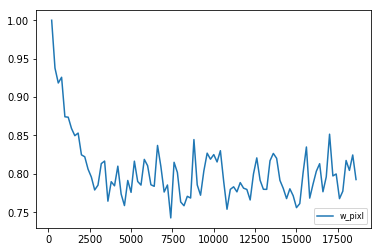

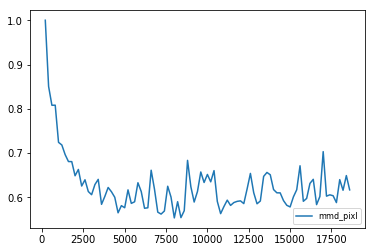

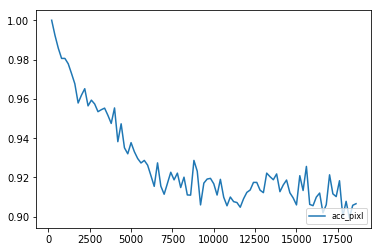

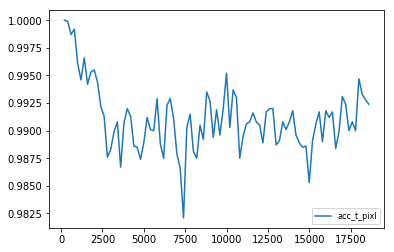

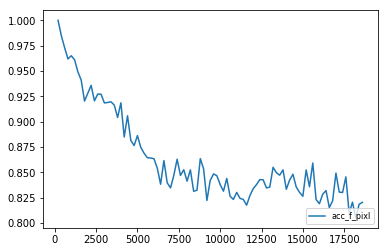

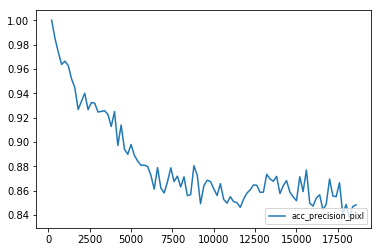

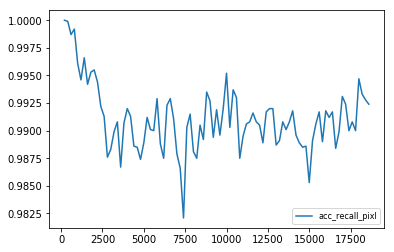

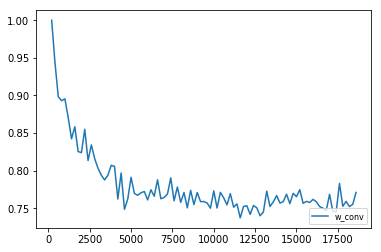

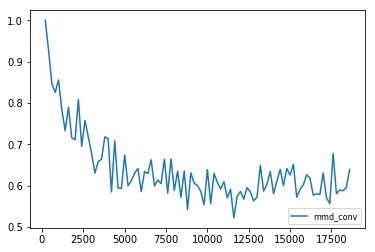

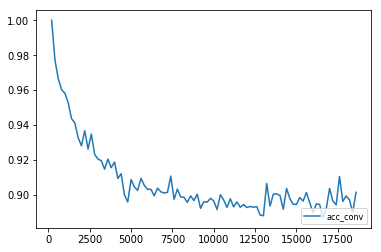

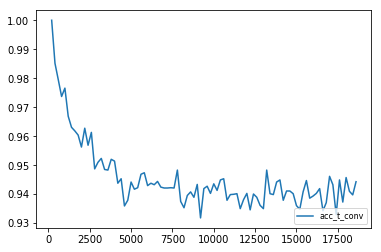

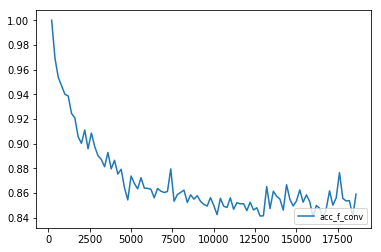

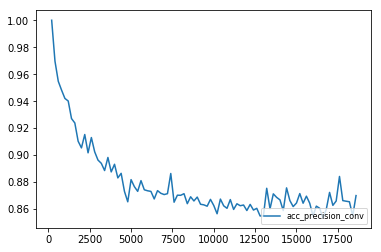

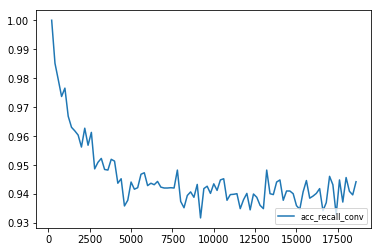

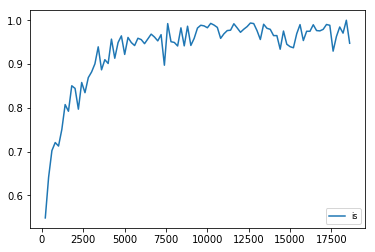

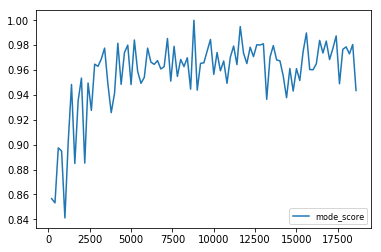

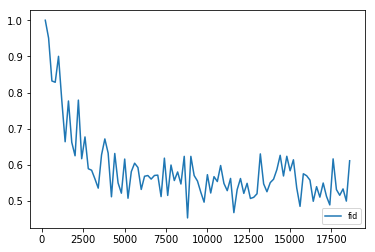

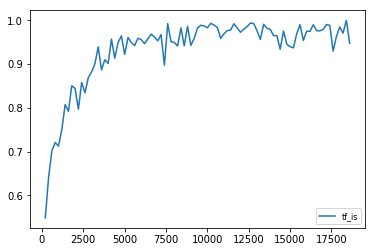

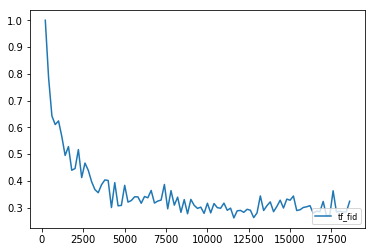

In [5]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.utils.data as Data
class INFOGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.num_classes = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 72
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []
        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', self.mutual_info_loss]

        # Build and the discriminator and recognition network
        self.discriminator, self.auxilliary = self.build_disk_and_q_net()

        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the recognition network Q
        self.auxilliary.compile(loss=[self.mutual_info_loss],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        gen_input = Input(shape=(self.latent_dim,))
        img = self.generator(gen_input)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        valid = self.discriminator(img)
        # The recognition network produces the label
        target_label = self.auxilliary(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(gen_input, [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        gen_input = Input(shape=(self.latent_dim,))
        img = model(gen_input)

        model.summary()

        return Model(gen_input, img)


    def build_disk_and_q_net(self):

        img = Input(shape=self.img_shape)

        # Shared layers between discriminator and recognition network
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())

        img_embedding = model(img)

        # Discriminator
        validity = Dense(1, activation='sigmoid')(img_embedding)

        # Recognition
        q_net = Dense(128, activation='relu')(img_embedding)
        label = Dense(self.num_classes, activation='softmax')(q_net)

        # Return discriminator and recognition network
        return Model(img, validity), Model(img, label)


    def mutual_info_loss(self, c, c_given_x):
        """The mutual information metric we aim to minimize"""
        eps = 1e-8
        conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
        entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

        return conditional_entropy + entropy

    def sample_generator_input(self, batch_size):
        # Generator inputs
        sampled_noise = np.random.normal(0, 1, (batch_size, 62))
        sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
        sampled_labels = to_categorical(sampled_labels, num_classes=self.num_classes)

        return sampled_noise, sampled_labels

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test,y_test) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        X_test = np.expand_dims(X_test, axis=3)
        y_test = y_test.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        global_step=0
        nb_batches = int(X_train.shape[0] / batch_size)
        for epoch in range(epochs):

            for index in range(nb_batches):
                global_step += 1
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                imgs = X_train[index * batch_size:(index + 1) * batch_size]
                labels = y_train[index * batch_size:(index + 1) * batch_size]
                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Sample noise and categorical labels
                sampled_noise, sampled_labels = self.sample_generator_input(batch_size)
                gen_input = np.concatenate((sampled_noise, sampled_labels), axis=1)

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(gen_input)

                # Train on real and generated data
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

                # Avg. loss
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator and Q-network
                # ---------------------

                g_loss = self.combined.train_on_batch(gen_input, [valid, sampled_labels])

                # Plot the progress
                print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))

                # If at save interval => save generated image samples
                sampleSize = 10000
            
                # If at save interval => save generated image samples
                if global_step % sample_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_infogan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()
    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize//10
        noise = np.random.normal(0, 1, (r * c,72))
#         sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=sampleSize, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=sampleSize, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
        # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
        # print(mnist_score)
        # print(f_distance)
        # s[14]=mnist_score
        # s[16]=f_distance
        s[17]=mnist_score
        s[18]=f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f'%(i) for i in s)
        f.writelines('\n')
        return s
    def sample_images(self, epoch):

        r, c = 10, 10
        gen_imgss=[]
        for i in range(c):
            sampled_noise, _ = self.sample_generator_input(c)
            label = to_categorical(np.full(fill_value=i, shape=(r,1)), num_classes=self.num_classes)
            gen_input = np.concatenate((sampled_noise, label), axis=1)
            gen_imgs = self.generator.predict(gen_input)
#             print(gen_imgs.shape)
            gen_imgs = 0.5 * gen_imgs + 0.5
            for j in range(r):
                gen_imgss.append(gen_imgs[j,:,:,0])
        gen_imgss=np.array(gen_imgss)
        for i,gen_img in enumerate(gen_imgss):
            fig, axs = plt.subplots(1, 1)
            axs.imshow(gen_img, cmap='gray')
            # plt.show()
            axs.axis('off')

            if not os.path.isdir('mnist_images/{}'.format(epoch)):
                os.mkdir('mnist_images/{}'.format(epoch))
            # fig.savefig("images/%d.png" % cnt)
            fig.savefig('mnist_images/{}/{}.png'.format(epoch, i+1))
            plt.close()
    

if __name__ == '__main__':
    infogan = INFOGAN()
    infogan.train(epochs=20, batch_size=64, sample_interval=200)
